This post brings together the components for the processing unit.

In [1]:
import numpy as np
from src.var_processor.covariance import CovarianceUnit
from src.var_processor.power_iterator import PowerIterator


def project(input_data, ev):
    """Project input using eigenvector.
    
    Args:
        input_data: 1D numpy array of length 'size'.
        ev: eigenvector - 1D numpy array of length 'size'.
    """
    return np.dot(ev.T, input_data)
    
    
def reconstruct(ev, r):
    """Reconstruct a version of the input using projected input.
        
    Args:
        ev: eigenvector - 1D numpy array of length 'size'.
        r: a scalar indicating a projection.
    """
    return r*ev


class VPU:
    """Variance processing unit."""
    
    def __init__(self, size):
        """Initialise.

        Args:
            size: integer setting the 1D size of an input;
        """
        self.cu = CovarianceUnit(size)
        self.pi = PowerIterator(size)
        self.size = size
    
    def iterate(self, input_data):
        """Iterate through one discrete timestep.
        
        Args:
            input_data: 1D numpy array of length self.size.
            
        Returns:
            residual: input minus the reconstructed input (1D array)
            r: scalar feature detection output
        """
        # Update covariance matrix
        self.update_cov(input_data)
        cov = self.cu.covariance
        # Power iterate
        self.pi.iterate(cov=cov)
        ev = self.pi.eigenvector
        # Project
        r = project(input_data, ev)
        r = self.process_r(r)
        # Reconstruct
        input_hat = reconstruct(ev, r)
        # Determine output
        residual = input_data - input_hat
        return r, residual
    
    def update_cov(self, input_data):
        """Update the covariance matrix.
        
        Use this to bed in the covariance.
        
        Args:
            input_data: 1D numpy array of length self.size."""
        self.cu.update(input_data)
        
    def process_r(self, r):
        """Perform post-processing on scalar r.
        
        Args:
            r: scalar.
        """
        return r
        
    def reset(self):
        """Reset and clear."""
        self.__init__(self.size)

Function to generate random inputs for testing.

In [33]:
def random_binary(size):
    """Generate a random binary 1D array.
    
    Args:
        high: largest random int.
        size: integer length of 1D array.
        
    Returns:
        a 1D array of length size.
    """
    while True:
        yield np.random.randint(2, size=(size,1))

In [34]:
for i in range(0, 100):
    next(random_binary(3))

In [4]:
input_data = next(random_binary(9))
ev = next(random_binary(9))
ev = ev / ev.sum()
r = project(input_data, ev)
print(r, r.shape)

[[1.]] (1, 1)


In [5]:
def test_project():
    input_data = next(random_binary(3))
    ev = next(random_binary(3))
    ev = ev / ev.sum()
    r = project(input_data, ev)
    assert r.shape == (1,1)
    
def test_reconstruct():
    r = np.asarray([[1.]])
    ev = np.ones(shape=(3,1))
    ev = ev / ev.sum()
    rec_signal = reconstruct(ev, r)
    assert np.array_equal(rec_signal, ev)

In [6]:
test_project()

In [7]:
test_reconstruct()

Now we need to think how to visualise.

Ideally, we want:
1) A view of the input;
2) A view of r; and
3) A view of the residual.

1) and 3) will be 1D arrays - best viewed as bar charts. 2) can be view as a single bar

In [8]:
vpu = VPU(9)

self = vpu

v = next(random_binary(9))
self.cu.update(v)
print(v, self.cu.covariance)

[[0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]] [[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


Ah - no problem is our random binary input may be all 0s!

In [9]:
v = next(random_binary(9))
self.cu.update(v)
print(self.cu.covariance)

[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.08333333 -0.08333333  0.          0.08333333 -0.08333333
  -0.08333333 -0.08333333  0.        ]
 [ 0.         -0.08333333  0.08333333  0.         -0.08333333  0.08333333
   0.08333333  0.08333333  0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.08333333 -0.08333333  0.          0.08333333 -0.08333333
  -0.08333333 -0.08333333  0.        ]
 [ 0.         -0.08333333  0.08333333  0.         -0.08333333  0.08333333
   0.08333333  0.08333333  0.        ]
 [ 0.         -0.08333333  0.08333333  0.         -0.08333333  0.08333333
   0.08333333  0.08333333  0.        ]
 [ 0.         -0.08333333  0.08333333  0.         -0.08333333  0.08333333
   0.08333333  0.08333333  0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]


I think we need a "bedding in period" - 10 or 100 iterations.

We also need tests for both the covariance and the threshold functions.

But if we initialise to the identity matrix we are not able to power iterate.

## Visualisers

We can build on on matplotlib visualisers for audio data.

In [26]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time


class VPUVisualizer:
    """Object to visualise VPU."""

    def __init__(self, VPU, input_generator):
        """Initialise.
        
        Args:
            VPU: VPU object.
            input_generator: generator object that outputs an input for
            each iteration.
        """
        self.VPU = VPU
        self.input_gen = input_generator
        # Get array size
        size = VPU.size
        # Initialise subplots with 3 figs
        self.figure, self.axes = plt.subplots(1, 4)
        # Initialising animation
        self.animation = FuncAnimation(
            self.figure, self.update, save_count=200)
        # Initialise arrays - need shape (size,)
        self.input_array = self.residual_array = np.zeros(shape=(size, ))
        # Initialise Array Element (X) Axis
        self.x_range = np.arange(0, size)
        self.binary_range = np.arange(0, 1)
        # Configuring subplots
        self.input_plot = self.axes[0].bar(
            self.x_range, self.input_array, color='y')
        self.axes[0].set_xlabel("Array Element")
        self.axes[0].set_title("Input Data")
        self.residual_plot = self.axes[1].bar(
            self.x_range, self.residual_array, color='r')
        self.axes[1].set_xlabel("Array Element")
        self.axes[1].set_title("Residual Data")
        # 3rd Plot shows R scalar output
        self.r_plot = self.axes[2].bar(
            self.binary_range, self.binary_range, color='k')
        self.axes[2].set_title("R")
        # Third subplot for the eigenvector
        self.ev_plot = self.axes[3].bar(
            self.x_range, self.input_array, color='b')
        self.axes[3].set_xlabel("Array Element")
        self.axes[3].set_title("Eigenvector")
        self.size = size
        for ax in self.axes:
            ax.xaxis.set_major_locator(plt.NullLocator())
            #ax.yaxis.set_major_locator(plt.NullLocator())
        plt.subplots_adjust(wspace = 0.5)
        
        # Bed in VPU
        for i in range(0,100):
            input_data = next(self.input_gen)
            self.VPU.update_cov(input_data)
        print("finish")

    def update(self, frame):
        """Update the visualisations."""
        # Get input data
        #print("updating")
        input_data = next(self.input_gen)
        r, residual = self.VPU.iterate(input_data)
        self.input_plot.remove()
        self.input_plot = self.axes[0].bar(
            self.x_range, 
            input_data.reshape(self.size ,),
            color='y')
        self.residual_plot.remove()
        self.residual_plot = self.axes[1].bar(
            self.x_range, 
            residual.reshape(self.size ,),
            color='r')
        self.r_plot.remove()
        self.r_plot = self.axes[2].bar(
            self.binary_range, 
            r.reshape(1,),
            color='k'
        )
        self.ev_plot.remove()
        self.ev_plot = self.axes[3].bar(
            self.x_range, 
            self.VPU.pi.eigenvector.reshape(self.size,),
            color='b'
        )
        time.sleep(0.25)
        return self.figure

    def show(self):
        """Show the visualisations."""
        plt.show()


<IPython.core.display.Javascript object>


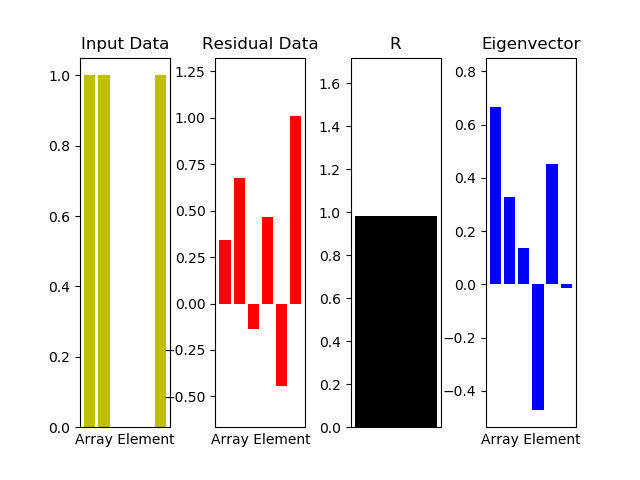

finish


In [35]:
%matplotlib notebook
size = 6
vpu = VPU(size)
visualiser = VPUVisualizer(vpu, random_binary(size))
visualiser.show()

In [36]:
visualiser.input_gen

<generator object random_binary at 0x7fe8321e63b8>

In [40]:
next(visualiser.input_gen)

array([[1],
       [0],
       [0],
       [0],
       [0],
       [0]])

Interesting - sometimes it becomes unstable and r and the residual "blow-up". Applying a non-linearity to r would stop that.

It looks like we want to apply a clamp operation to keep things between 0 and 1?

See - https://matplotlib.org/gallery/ticks_and_spines/custom_ticker1.html#sphx-glr-gallery-ticks-and-spines-custom-ticker1-py for bar graph visualisations.

## Clamping Output

We have several options:
* Apply a non-linearity to clamp r between 0 and 1.
* We can use our probablistic thresholding - e.g. r could be seen as a probability that we sample.
* If we clamp r before we reconstruct we get a residual that is also within the range of -1 to 1.

In [13]:
np.random.rand()

0.6063906594568607

In [14]:
class VPU_nonlin(VPU):
    """VPU with non-linear clamping."""
    
    def process_r(self, r):
        """Perform post-processing on scalar r.
        
        Args:
            r: scalar.
        """
        return np.clip(r, 0, 1)

<IPython.core.display.Javascript object>


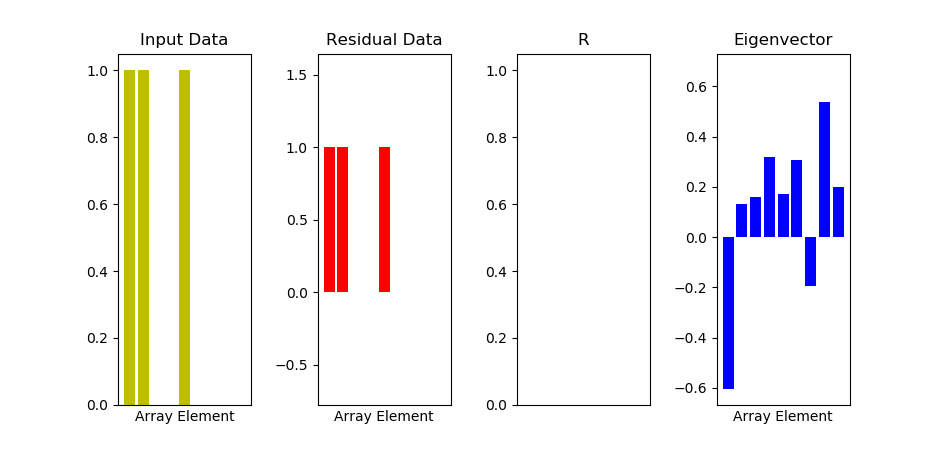

finish


In [28]:
%matplotlib notebook
size = 9
vpu = VPU_nonlin(size)
visualiser = VPUVisualizer(vpu, random_binary(size))
visualiser.show()

Even with clamping the residual data sometimes grows large. This must be because we have large negative ev values. But ev should be normalised to unit length...

Is it because we are using the L-1 norm (via ev.sum()) to normalise yet the eigenvector values may be negative so we actually want the L2-norm.

R looks like it could be binary - values are normally high or low or 0.